<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Encoder_logistic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4045, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 4045 (delta 145), reused 197 (delta 58), pack-reused 3722
Receiving objects: 100% (4045/4045), 682.57 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (730/730), done.
Checking out files: 100% (2861/2861), done.
/content/STAT3007_Project/STAT3007_Project


In [7]:
pip install colorednoise

In [8]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np


configure the device

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

True


In [25]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Mounted at /content/drive


load the spectrogram data, 40 snr

In [26]:
noisy_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_6.npy')
clean_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_6.npy')
targets_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/target_6.npy')


noisy_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4.npy')
clean_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4.npy')
targets_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4.npy')

noisy_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_8.npy')
noisy_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_2.npy')
clean_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_8.npy')
clean_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_2.npy')
targets_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_8.npy')
targets_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_2.npy')





In [27]:
noisy_6 = noisy_6.reshape(noisy_6.shape[0],1,noisy_6.shape[1],noisy_6.shape[2])
clean_6 = clean_6.reshape(clean_6.shape[0],1,clean_6.shape[1],clean_6.shape[2])

noisy_4 = noisy_4.reshape(noisy_4.shape[0],1,noisy_4.shape[1],noisy_4.shape[2])
clean_4 = clean_4.reshape(clean_4.shape[0],1,clean_4.shape[1],clean_4.shape[2])

noisy_4_8 = noisy_4_8.reshape(noisy_4_8.shape[0],1,noisy_4_8.shape[1],noisy_4_8.shape[2])
clean_4_8 = clean_4_8.reshape(clean_4_8.shape[0],1,clean_4_8.shape[1],clean_4_8.shape[2])
noisy_4_2 = noisy_4_2.reshape(noisy_4_2.shape[0],1,noisy_4_2.shape[1],noisy_4_2.shape[2])
clean_4_2 = clean_4_2.reshape(clean_4_2.shape[0],1,clean_4_2.shape[1],clean_4_2.shape[2])

In [28]:
denoise_train = DatasetWrapper(torch.tensor(noisy_6), torch.tensor(clean_6))
denoise_test = DatasetWrapper(torch.tensor(noisy_4), torch.tensor(clean_4))

# Network Architecture

In [29]:
# Autoencoder with optimal hyper-parameters already put in
class Encoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4)):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size1),
                              nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size2),
                              nn.ConvTranspose2d(filters,1, kernel_size = kernal_size),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters, kernal_size=(3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.kernal_size = kernal_size
    self.upsample_size1 = upsample_size1
    self.upsample_size2 = upsample_size2
    self.encoder = Encoder(filters, kernal_size)
    self.decoder = Decoder(filters, kernal_size, upsample_size1, upsample_size2)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# Save state_dict()

In [30]:
state_save_path = '/content/drive/MyDrive/STAT3007_project/denoised_saved_model'
#torch.save(net.state_dict(), state_save_path)
model = torch.load(state_save_path)

In [31]:
model

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(4, 2), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
      (4): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): ConvTranspose2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
      (1): ReLU()
      (2): Upsample(size=(59, 30), mode=nearest)
      (3): ConvTranspose2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
      (4): ReLU()
      (5): Upsample(size=(125, 62), mode=nearest)
      (6): ConvTranspose2d(8, 1, kernel_size=(4, 2), stride=(1, 1))
    )
  )
)

<class '__main__.Autoencoder'>


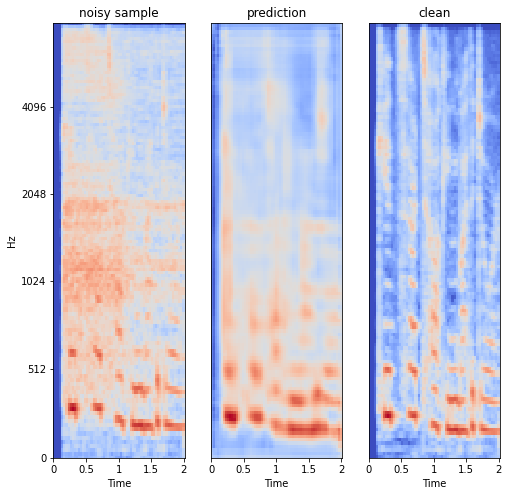

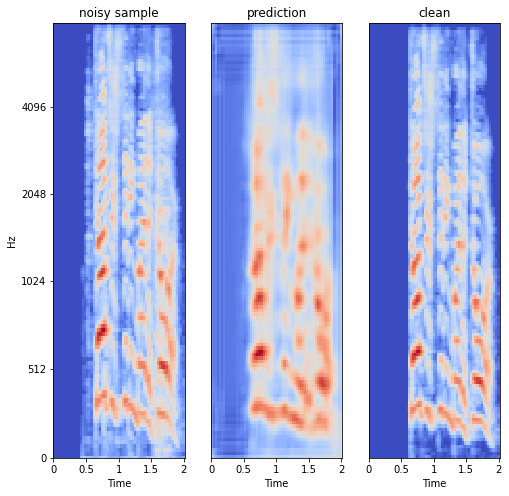

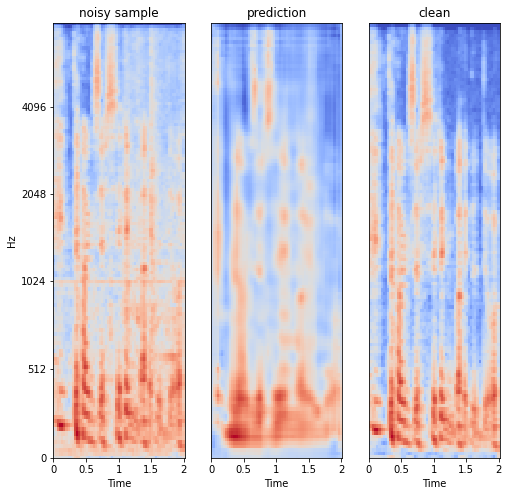

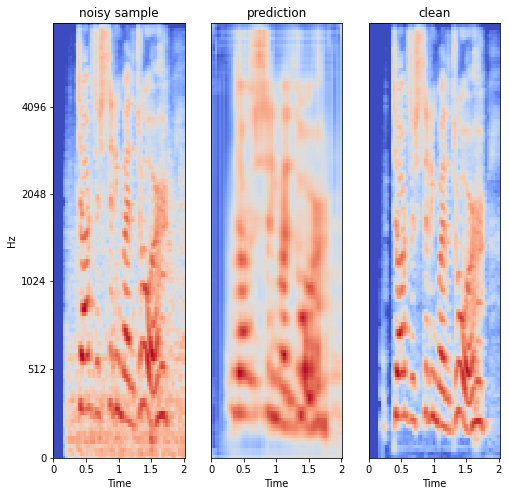

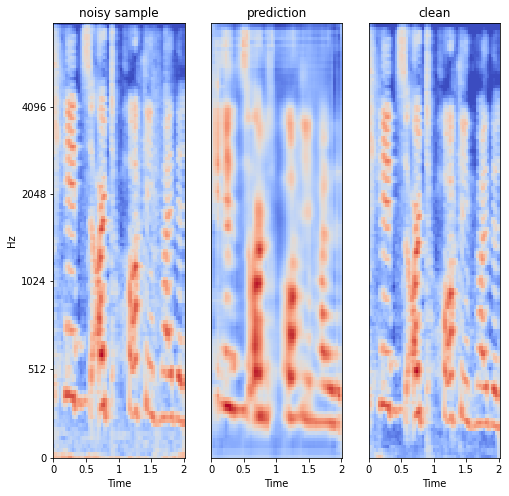

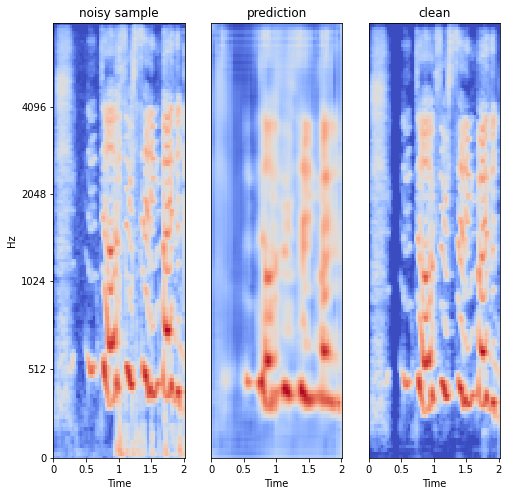

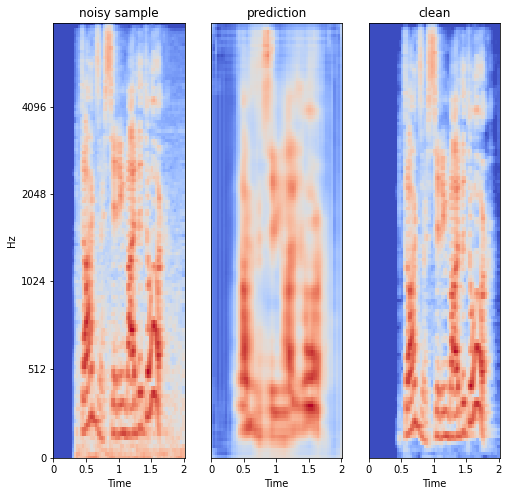

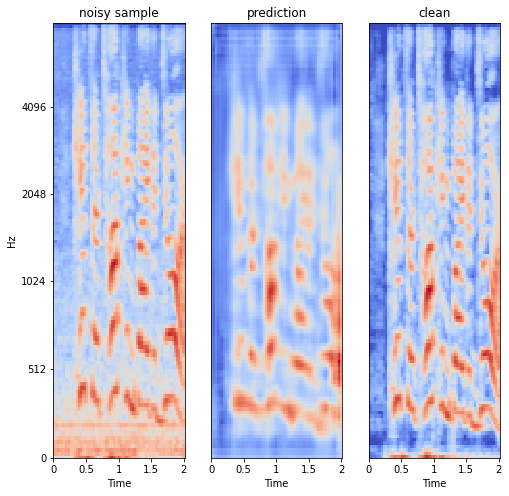

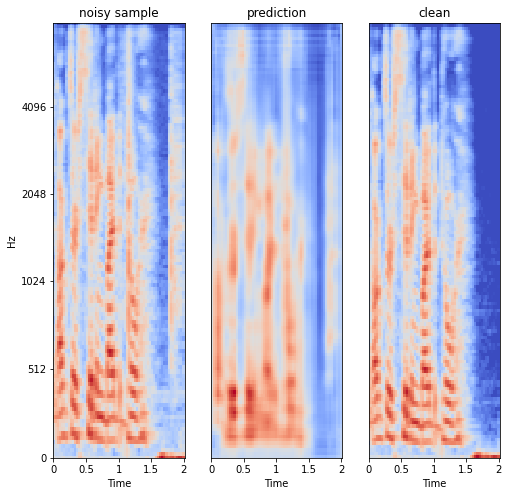

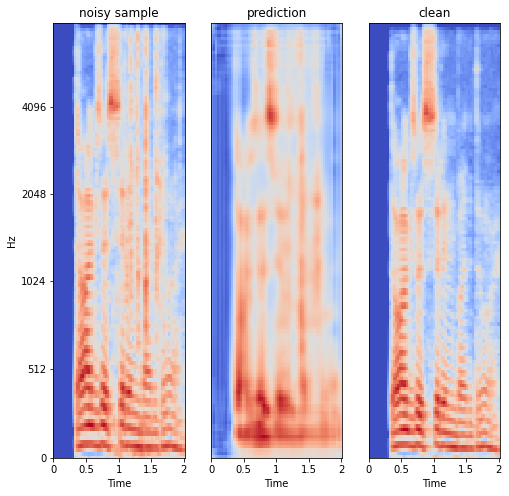

In [32]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    model = model.to(torch.device('cpu'))
print(type(model))
y_pred = model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

In [33]:
model.encoder

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
    (8): ReLU()
  )
)

In [34]:
encoder = model.encoder

In [35]:
X_train_feature = encoder(torch.tensor(noisy_4_8)).detach()
X_test_feature = encoder(torch.tensor(noisy_4_2)).detach()

y_train = torch.tensor(targets_4_8)
y_test = torch.tensor(targets_4_2)

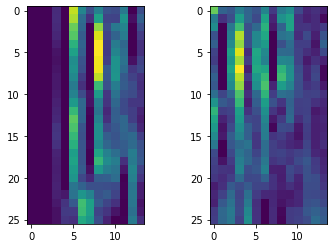

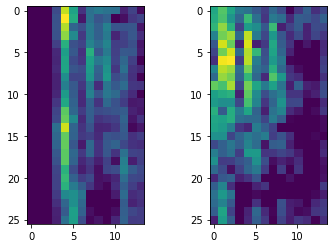

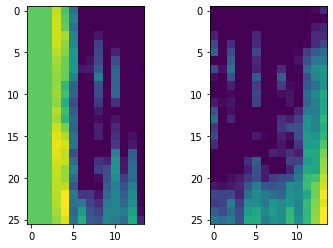

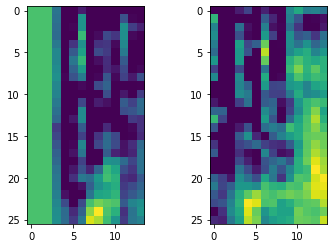

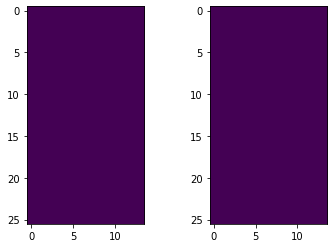

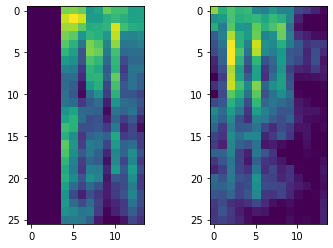

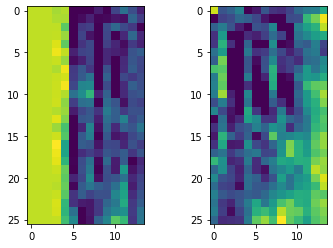

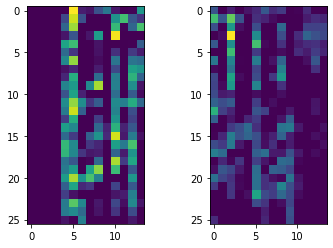

In [39]:
a = np.random.random(2)

a = (a * 378)//1

for i in range(8):
  plt.figure()
  plt.subplot(121)
  plt.imshow(X_train_feature[int(a[0])][i])
  plt.subplot(122)
  plt.imshow(X_train_feature[int(a[1])][i])

#  logistic regression

In [40]:
X_train_flat, X_test_flat =  torch.flatten(X_train_feature,start_dim = 1).numpy(),torch.flatten(X_test_feature,start_dim = 1).numpy()

In [41]:

# building a naive bayes classifier
def classification_model(X_train,y_train, X_test, y_test):
  NB = MultinomialNB()
  NB.fit(X_train,y_train)
  y_pred = NB.predict(X_test)

  # metrics
  # count correctly classified samples
  correct_count = np.count_nonzero(y_pred == y_test)
  accuracy = metrics.accuracy_score(y_test,y_pred)
  balanced_accuracy = metrics.balanced_accuracy_score(y_test,y_pred)

  print('total sample counts:',y_pred.shape[0])
  print('correct classification counts:',correct_count,'(',accuracy * 100,'%)')
  print('{0}: {1:.1%}'.format('balanced accuracy', balanced_accuracy))
  print('misclasification counts:',y_pred.shape[0] - correct_count,'(',(1 - accuracy)*100,'%)')

  return NB

In [47]:
for i in range(5):
  print(np.where(y_test == i)[0].shape[0]/y_test.shape[0])

0.15789473684210525
0.21052631578947367
0.18947368421052632
0.16842105263157894
0.2736842105263158


In [89]:
NB = classification_model(X_train_flat,y_train.detach().numpy(), X_test_flat, y_test.detach().numpy())

total sample counts: 95
correct classification counts: 54 ( 56.84210526315789 %)
balanced accuracy: 56.8%
misclasification counts: 41 ( 43.15789473684211 %)


In [90]:
y_pred = NB.predict(X_test_flat)

In [51]:
y_pred

array([2, 1, 3, 2, 2, 1, 1, 3, 1, 4, 1, 1, 0, 0, 0, 3, 4, 1, 0, 4, 4, 3,
       4, 2, 1, 1, 4, 3, 2, 3, 1, 0, 4, 4, 0, 4, 3, 0, 4, 4, 3, 0, 4, 4,
       0, 1, 2, 1, 1, 4, 0, 0, 0, 0, 3, 4, 4, 3, 3, 4, 4, 4, 4, 1, 0, 2,
       0, 2, 1, 2, 0, 4, 4, 0, 2, 4, 3, 3, 3, 4, 4, 4, 3, 0, 4, 3, 1, 3,
       3, 1, 0, 3, 0, 0, 2])

In [93]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred, normalize = 'true')
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)

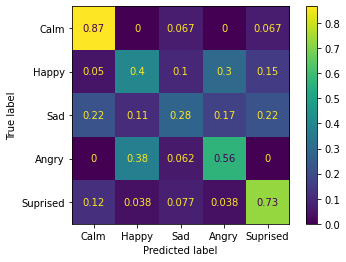

In [94]:
thing.plot()

# CNN model

In [65]:
import CNN_Model
import data_loading

In [72]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []

  test_loss = []
  avg_loss = []
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)

  X_test,y_test = data_test.get_data()

  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      

      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()


      pred = net(X_batch)
      Rn = loss(pred, y_batch)
      accur = CNN_Model.accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()


    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)
    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    pred = net(X_test)
    Rn = loss(pred, y_test)
    accur = CNN_Model.accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc

In [66]:
data_train = data_loading.DatasetWrapper(X_train_feature,y_train)
data_test = data_loading.DatasetWrapper(X_test_feature,y_test)


In [73]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)
CNN = CNN_Model.ConvNet_MultiChannel(channels=8, contain_linear=True)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, CNN,loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 1.0663479566574097


In [75]:
final_array = np.array([avg_loss,test_loss,avg_acc,test_acc])
np.save('/content/drive/MyDrive/STAT3007_project/CNN_Models_Results/encoder_CNN.npy',final_array)

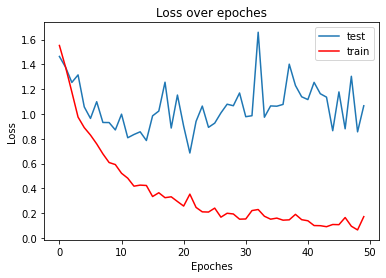

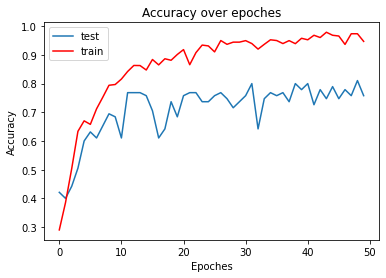

In [74]:
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()

In [99]:
import sklearn

X_test,y_test = data_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = CNN_Model.classification(pred)


labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred, normalize = None)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)

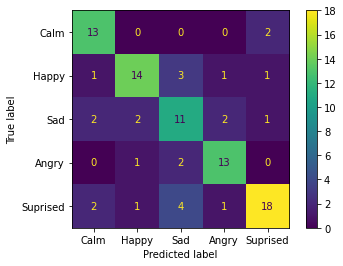

In [100]:
thing.plot()